# ScoreSight - Match Winner Prediction
Author: Rishi Khandekar  
Internship: Infosys  
Goal: Predict Match Winner (Win/Draw/Loss)

In [1]:
!pip install seaborn xgboost


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

sns.set(style="whitegrid", palette="pastel", font_scale=1.1)

In [3]:
df = pd.read_csv("Match Winner.csv")
print("Shape of dataset:", df.shape)
display(df.head())

Shape of dataset: (9380, 22)


,Season,MatchDate,HomeTeam,AwayTeam,FullTimeHomeGoals,FullTimeAwayGoals,FullTimeResult,HalfTimeHomeGoals,HalfTimeAwayGoals,HalfTimeResult,...,HomeShotsOnTarget,AwayShotsOnTarget,HomeCorners,AwayCorners,HomeFouls,AwayFouls,HomeYellowCards,AwayYellowCards,HomeRedCards,AwayRedCards
0,2000/01,2000-08-19,Charlton,Man City,4,0,H,2,0,H,...,14,4,6,6,13,12,1,2,0,0
1,2000/01,2000-08-19,Chelsea,West Ham,4,2,H,1,0,H,...,10,5,7,7,19,14,1,2,0,0
2,2000/01,2000-08-19,Coventry,Middlesbrough,1,3,A,1,1,D,...,3,9,8,4,15,21,5,3,1,0
3,2000/01,2000-08-19,Derby,Southampton,2,2,D,1,2,A,...,4,6,5,8,11,13,1,1,0,0
4,2000/01,2000-08-19,Leeds,Everton,2,0,H,2,0,H,...,8,6,6,4,21,20,1,3,0,0


In [4]:
drop_cols = [
    "Season", "MatchDate",
    "FullTimeHomeGoals", "FullTimeAwayGoals",
    "HalfTimeHomeGoals", "HalfTimeAwayGoals", "HalfTimeResult"
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

print("Remaining Columns:", df.columns.tolist())
print("\nMissing values per column:")
print(df.isnull().sum())

Remaining Columns: ['HomeTeam', 'AwayTeam', 'FullTimeResult', 'HomeShots', 'AwayShots', 'HomeShotsOnTarget', 'AwayShotsOnTarget', 'HomeCorners', 'AwayCorners', 'HomeFouls', 'AwayFouls', 'HomeYellowCards', 'AwayYellowCards', 'HomeRedCards', 'AwayRedCards']

Missing values per column:
HomeTeam             0
AwayTeam             0
FullTimeResult       0
HomeShots            0
AwayShots            0
HomeShotsOnTarget    0
AwayShotsOnTarget    0
HomeCorners          0
AwayCorners          0
HomeFouls            0
AwayFouls            0
HomeYellowCards      0
AwayYellowCards      0
HomeRedCards         0
AwayRedCards         0
dtype: int64


In [5]:
# Show cleaned dataset after cleaning
display(df.head())

,HomeTeam,AwayTeam,FullTimeResult,HomeShots,AwayShots,HomeShotsOnTarget,AwayShotsOnTarget,HomeCorners,AwayCorners,HomeFouls,AwayFouls,HomeYellowCards,AwayYellowCards,HomeRedCards,AwayRedCards
0,Charlton,Man City,H,17,8,14,4,6,6,13,12,1,2,0,0
1,Chelsea,West Ham,H,17,12,10,5,7,7,19,14,1,2,0,0
2,Coventry,Middlesbrough,A,6,16,3,9,8,4,15,21,5,3,1,0
3,Derby,Southampton,D,6,13,4,6,5,8,11,13,1,1,0,0
4,Leeds,Everton,H,17,12,8,6,6,4,21,20,1,3,0,0


In [6]:
target = "FullTimeResult"
X = df.drop(columns=[target])
y = df[target]

print("Target distribution:\n", y.value_counts())

label_enc = LabelEncoder()
y_encoded = label_enc.fit_transform(y)

Target distribution:
 FullTimeResult
H    4299
A    2768
D    2313
Name: count, dtype: int64


In [7]:
X_encoded = pd.get_dummies(X, columns=["HomeTeam", "AwayTeam"], drop_first=True)
print("Shape after encoding:", X_encoded.shape)

Shape after encoding: (9380, 102)


In [8]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

numeric_cols = X_encoded.select_dtypes(include=np.number).columns
for col in list(numeric_cols)[:5]:
    print(f"{col}: {len(detect_outliers_iqr(X_encoded, col))} outliers")

HomeShots: 129 outliers
AwayShots: 81 outliers
HomeShotsOnTarget: 148 outliers
AwayShotsOnTarget: 325 outliers
HomeCorners: 99 outliers


C:\Users\rishi\AppData\Local\Temp\ipykernel_25348\243342576.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette=sns.color_palette("muted", 3))


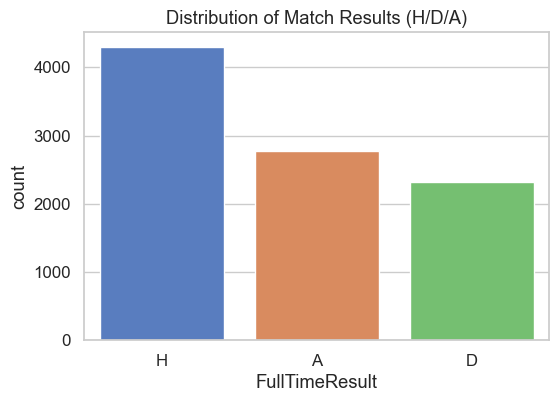

In [9]:
plt.figure(figsize=(6,4))
sns.countplot(x=y, palette=sns.color_palette("muted", 3))
plt.title("Distribution of Match Results (H/D/A)")
plt.show()

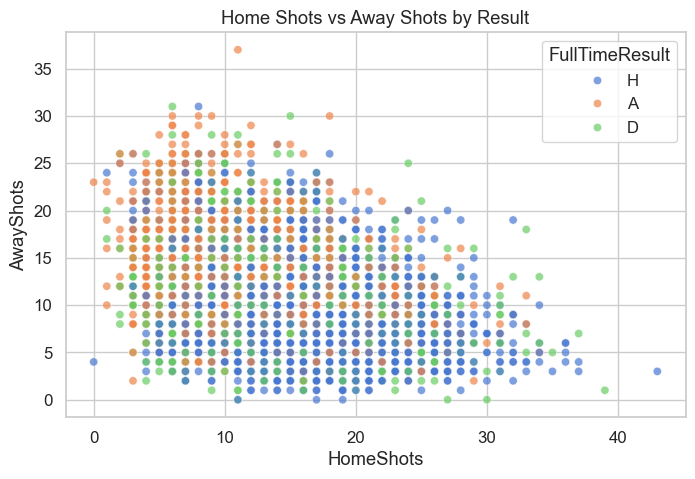

In [10]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x="HomeShots", y="AwayShots", hue=y, alpha=0.7, palette=sns.color_palette("muted", 3))
plt.title("Home Shots vs Away Shots by Result")
plt.show()

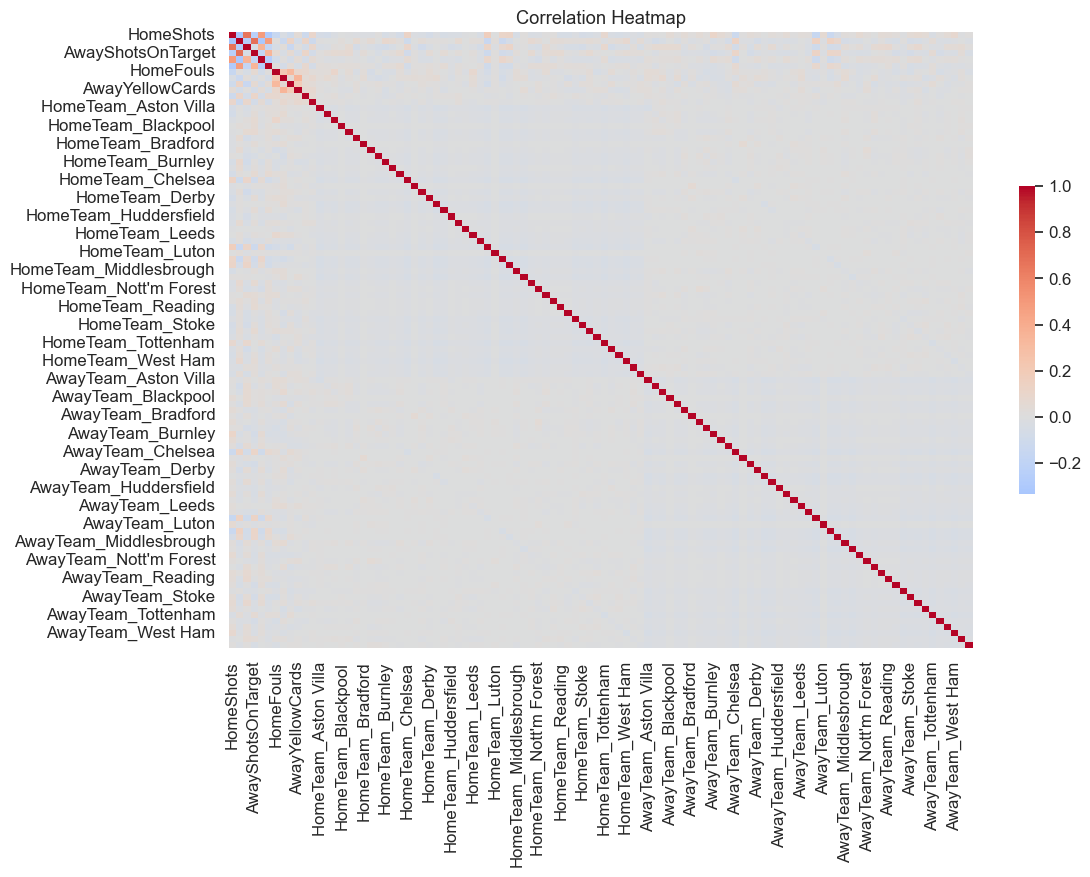

In [11]:
plt.figure(figsize=(12,8))
corr = X_encoded.corr()
sns.heatmap(corr, cmap="coolwarm", center=0, cbar_kws={'shrink':0.5})
plt.title("Correlation Heatmap")
plt.show()

C:\Users\rishi\AppData\Local\Temp\ipykernel_25348\2253459255.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=y, y=df["HomeRedCards"], palette=sns.color_palette("Set2", 3))


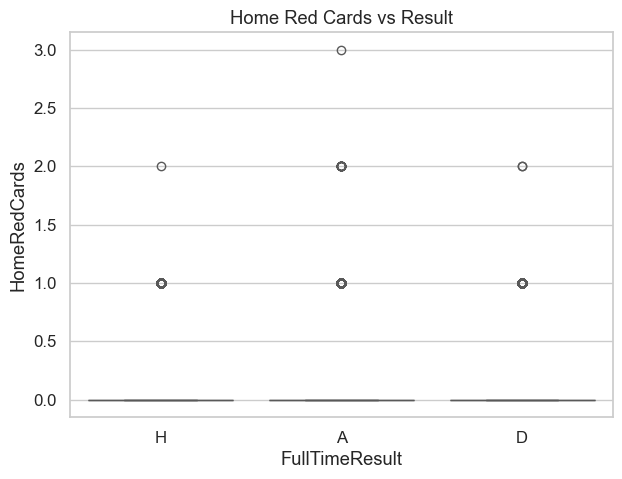

In [12]:
plt.figure(figsize=(7,5))
sns.boxplot(x=y, y=df["HomeRedCards"], palette=sns.color_palette("Set2", 3))
plt.title("Home Red Cards vs Result")
plt.show()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (7504, 102)
Test shape: (1876, 102)


In [14]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"\n📌 Results for {model_name}:")
    print("Accuracy:", model.score(X_test, y_test))
    print(classification_report(y_test, y_pred, target_names=label_enc.classes_))
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_enc.classes_)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

## 🔹 Week 3: Preliminary Model Training

C:\Users\rishi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



📌 Results for Logistic Regression:
Accuracy: 0.5831556503198294
              precision    recall  f1-score   support

           A       0.57      0.65      0.61       554
           D       0.30      0.08      0.12       462
           H       0.62      0.81      0.70       860

    accuracy                           0.58      1876
   macro avg       0.50      0.51      0.48      1876
weighted avg       0.53      0.58      0.53      1876



C:\Users\rishi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


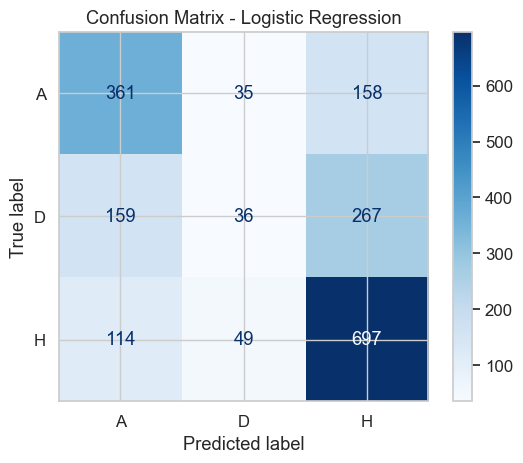

In [15]:
log_reg = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')
evaluate_model(log_reg, X_train, y_train, X_test, y_test, "Logistic Regression")


📌 Results for Random Forest Classifier:
Accuracy: 0.5613006396588486
              precision    recall  f1-score   support

           A       0.54      0.58      0.55       554
           D       0.29      0.06      0.10       462
           H       0.60      0.82      0.69       860

    accuracy                           0.56      1876
   macro avg       0.47      0.49      0.45      1876
weighted avg       0.50      0.56      0.51      1876



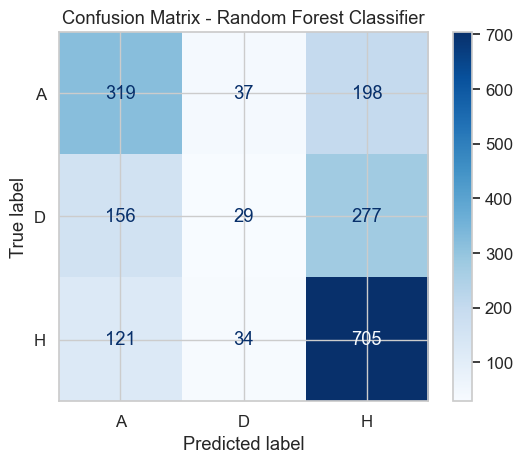

In [16]:
rf_clf = RandomForestClassifier(n_estimators=200, random_state=42)
evaluate_model(rf_clf, X_train, y_train, X_test, y_test, "Random Forest Classifier")


📌 Results for XGBoost Classifier:
Accuracy: 0.570362473347548
              precision    recall  f1-score   support

           A       0.56      0.60      0.58       554
           D       0.31      0.15      0.20       462
           H       0.63      0.78      0.70       860

    accuracy                           0.57      1876
   macro avg       0.50      0.51      0.49      1876
weighted avg       0.53      0.57      0.54      1876



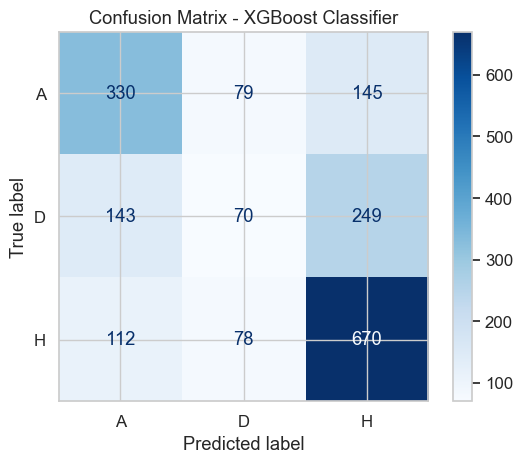

In [17]:
xgb_clf = XGBClassifier(eval_metric='mlogloss', random_state=42)
evaluate_model(xgb_clf, X_train, y_train, X_test, y_test, "XGBoost Classifier")

## 🌳 Week 4: Decision Tree Classifier


📌 Results for Decision Tree Classifier (Default):
Accuracy: 0.4664179104477612
              precision    recall  f1-score   support

           A       0.45      0.42      0.43       554
           D       0.29      0.29      0.29       462
           H       0.57      0.59      0.58       860

    accuracy                           0.47      1876
   macro avg       0.44      0.43      0.43      1876
weighted avg       0.46      0.47      0.47      1876



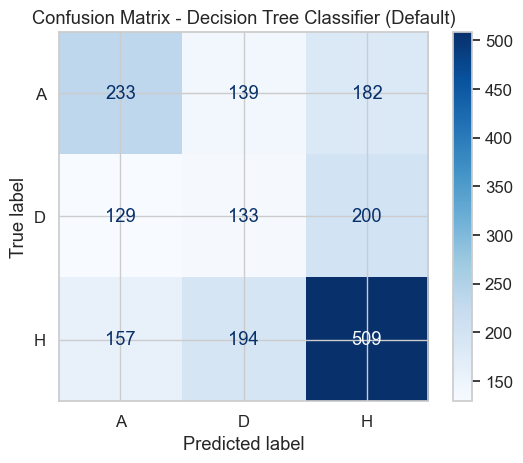

In [18]:
dt_clf = DecisionTreeClassifier(random_state=42)
evaluate_model(dt_clf, X_train, y_train, X_test, y_test, "Decision Tree Classifier (Default)")

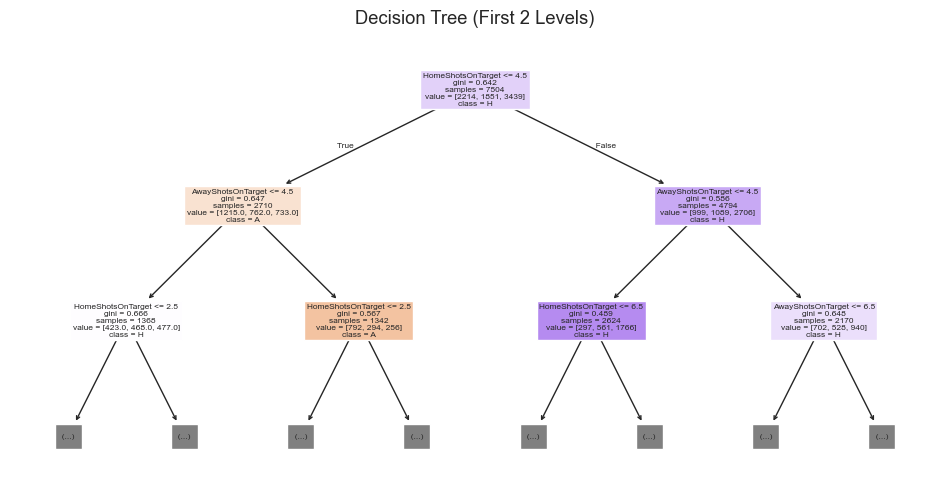

In [19]:
plt.figure(figsize=(12,6))
plot_tree(dt_clf, filled=True, feature_names=X_train.columns, class_names=label_enc.classes_, max_depth=2)
plt.title("Decision Tree (First 2 Levels)")
plt.show()

**Splitting Criteria:**

- Gini Impurity: Measures how often a randomly chosen element would be misclassified.
- Entropy (Information Gain): Measures the amount of information gained by a split.

Both are supported in scikit-learn via the `criterion` parameter.

Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}

📌 Results for Tuned Decision Tree Classifier:
Accuracy: 0.5479744136460555
              precision    recall  f1-score   support

           A       0.52      0.55      0.53       554
           D       0.38      0.04      0.07       462
           H       0.57      0.82      0.67       860

    accuracy                           0.55      1876
   macro avg       0.49      0.47      0.42      1876
weighted avg       0.51      0.55      0.48      1876



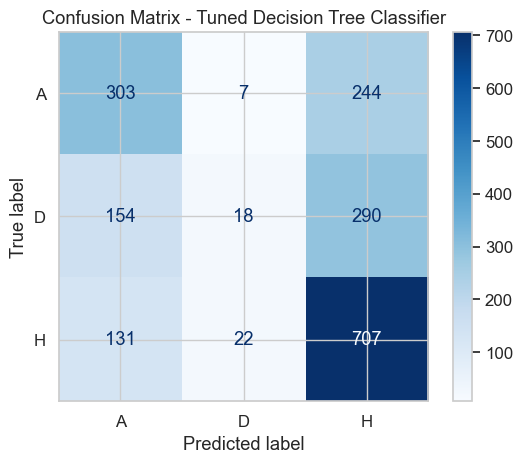

In [20]:
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5]
}

grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring="accuracy")
grid_dt.fit(X_train, y_train)

print("Best Parameters:", grid_dt.best_params_)
best_dt = grid_dt.best_estimator_
evaluate_model(best_dt, X_train, y_train, X_test, y_test, "Tuned Decision Tree Classifier")

In [21]:
print("Notebook End - Week 4 models completed.")

Notebook End - Week 4 models completed.


# 🔹 Week 4 Extended Experiments: SMOTE, Class Weights, and Combined Tuning
This section adds experiments to address class imbalance and improve accuracy. It does not modify your previous cells.

In [22]:
# Ensure imbalanced-learn is installed then import SMOTE
try:
    from imblearn.over_sampling import SMOTE
except Exception:
    import sys
    !{sys.executable} -m pip install -q imbalanced-learn
    from imblearn.over_sampling import SMOTE
print("imblearn SMOTE ready")

imblearn SMOTE ready


In [23]:
# Additional imports and robust helper functions for Week 4 experiments
import numpy as np, pandas as pd, warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.utils.class_weight import compute_class_weight

def evaluate_classifier(model, X_tr, y_tr, X_te, y_te, model_name='Model', sample_weight=None):
    if sample_weight is None:
        model.fit(X_tr, y_tr)
    else:
        model.fit(X_tr, y_tr, sample_weight=sample_weight)
    y_pred = model.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    print(f"\n📌 {model_name}")
    print(f"Accuracy: {acc:.4f}")
    print('Confusion Matrix:\n', confusion_matrix(y_te, y_pred))
    print('Classification Report:\n', classification_report(y_te, y_pred, target_names=(le.classes_ if 'le' in globals() else None)))
    return acc

def randomized_tune(estimator, param_dist, X, y, n_iter=20, cv=3, scoring='accuracy', sample_weight=None):
    rs = RandomizedSearchCV(estimator, param_distributions=param_dist, n_iter=n_iter, cv=cv, scoring=scoring, n_jobs=-1, random_state=42, verbose=0)
    if sample_weight is None:
        rs.fit(X, y)
    else:
        rs.fit(X, y, sample_weight=sample_weight)
    print('Best params:\n', rs.best_params_)
    return rs.best_estimator_, rs


In [24]:
# Compute class weights based on current y_train
try:
    classes = np.unique(y_train)
    cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
    class_weight_dict = dict(zip(classes, cw))
    print('Class weights:', class_weight_dict)
except NameError as e:
    print('y_train not found. Run earlier cells to create X_train/y_train. Error:', e)

Class weights: {np.int64(0): np.float64(1.1297801866907557), np.int64(1): np.float64(1.3513416171438861), np.int64(2): np.float64(0.7273432199282738)}


In [25]:
# Baseline: run default estimators (do not replace your previous baseline, this just records them here)
baseline_results = {}
try:
    from sklearn.linear_model import LogisticRegression
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier
    try:
        from xgboost import XGBClassifier
        xgb_available = True
    except Exception:
        xgb_available = False

    lr_def = LogisticRegression(max_iter=1000, random_state=42)
    baseline_results['Logistic Regression (Baseline)'] = evaluate_classifier(lr_def, X_train, y_train, X_test, y_test, 'Logistic Regression (Baseline)')

    dt_def = DecisionTreeClassifier(random_state=42)
    baseline_results['Decision Tree (Baseline)'] = evaluate_classifier(dt_def, X_train, y_train, X_test, y_test, 'Decision Tree (Baseline)')

    rf_def = RandomForestClassifier(random_state=42)
    baseline_results['Random Forest (Baseline)'] = evaluate_classifier(rf_def, X_train, y_train, X_test, y_test, 'Random Forest (Baseline)')

    if xgb_available:
        xgb_def = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
        baseline_results['XGBoost (Baseline)'] = evaluate_classifier(xgb_def, X_train, y_train, X_test, y_test, 'XGBoost (Baseline)')

    print('\nBaseline summary:')
    display(pd.DataFrame.from_dict(baseline_results, orient='index', columns=['Accuracy']).sort_values('Accuracy', ascending=False))
except Exception as e:
    print('Baseline evaluation failed. Ensure X_train/y_train/X_test/y_test are defined. Error:', e)


📌 Logistic Regression (Baseline)
Accuracy: 0.5832
Confusion Matrix:
 [[361  35 158]
 [159  36 267]
 [114  49 697]]
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.65      0.61       554
           1       0.30      0.08      0.12       462
           2       0.62      0.81      0.70       860

    accuracy                           0.58      1876
   macro avg       0.50      0.51      0.48      1876
weighted avg       0.53      0.58      0.53      1876


📌 Decision Tree (Baseline)
Accuracy: 0.4664
Confusion Matrix:
 [[233 139 182]
 [129 133 200]
 [157 194 509]]
Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.42      0.43       554
           1       0.29      0.29      0.29       462
           2       0.57      0.59      0.58       860

    accuracy                           0.47      1876
   macro avg       0.44      0.43      0.43      1876
weighted avg       

,Accuracy
Logistic Regression (Baseline),0.583156
XGBoost (Baseline),0.570362
Random Forest (Baseline),0.554904
Decision Tree (Baseline),0.466418


In [26]:
# Apply SMOTE on training set (multiclass SMOTE supported)
try:
    smote = SMOTE(random_state=42)
    X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
    print('After SMOTE class distribution:', np.bincount(y_train_sm))
except Exception as e:
    print('SMOTE failed:', e)

After SMOTE class distribution: [3439 3439 3439]


In [27]:
# Parameter distributions (moderate sizes for speed)
param_dist_lr = [
    {'penalty': ['l2'], 'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear']},
    {'penalty': ['l1'], 'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear', 'saga']}
]

param_dist_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_dist_rf = {
    'n_estimators': [100, 200, 400],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', None]
}

param_dist_xgb = {
    'n_estimators': [100, 200, 400],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

print('Parameter distributions defined.')

Parameter distributions defined.


In [28]:
# Run experiments: Tune on original, Tune on SMOTE, ClassWeight+Tune, SMOTE+ClassWeight+Tune
results = {}

# Logistic Regression experiments
from sklearn.linear_model import LogisticRegression
best_lr_orig, acc_lr_tuned = None, None
try:
    best_lr_orig, _ = randomized_tune(LogisticRegression(max_iter=1000, random_state=42), param_dist_lr, X_train, y_train, n_iter=10, cv=3)
    acc_lr_tuned = evaluate_classifier(best_lr_orig, X_train, y_train, X_test, y_test, 'Logistic Regression (Tuned on Original)')
    results['Logistic Regression (Tuned)'] = acc_lr_tuned
except Exception as e:
    print('LR tuning on original failed:', e)

# SMOTE tuning
try:
    best_lr_sm, _ = randomized_tune(LogisticRegression(max_iter=1000, random_state=42), param_dist_lr, X_train_sm, y_train_sm, n_iter=10, cv=3)
    acc_lr_sm = evaluate_classifier(best_lr_sm, X_train_sm, y_train_sm, X_test, y_test, 'Logistic Regression (Tuned on SMOTE)')
    results['Logistic Regression (SMOTE+Tuned)'] = acc_lr_sm
except Exception as e:
    print('LR tuning on SMOTE failed or SMOTE not available:', e)

# Class weight tuned (use estimator with class_weight and tune other params)
try:
    best_lr_cw, _ = randomized_tune(lambda: LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42), param_dist_lr, X_train, y_train, n_iter=10, cv=3)
    acc_lr_cw = evaluate_classifier(best_lr_cw, X_train, y_train, X_test, y_test, 'Logistic Regression (ClassWeight+Tuned)')
    results['Logistic Regression (ClassWeight+Tuned)'] = acc_lr_cw
except Exception as e:
    print('LR class-weight tuning failed:', e)

# SMOTE + ClassWeight
try:
    best_lr_sm_cw, _ = randomized_tune(lambda: LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42), param_dist_lr, X_train_sm, y_train_sm, n_iter=10, cv=3)
    acc_lr_sm_cw = evaluate_classifier(best_lr_sm_cw, X_train_sm, y_train_sm, X_test, y_test, 'Logistic Regression (SMOTE+ClassWeight+Tuned)')
    results['Logistic Regression (SMOTE+ClassWeight+Tuned)'] = acc_lr_sm_cw
except Exception as e:
    print('LR SMOTE+CW tuning failed:', e)

# Decision Tree experiments
from sklearn.tree import DecisionTreeClassifier
try:
    best_dt_orig, _ = randomized_tune(DecisionTreeClassifier(random_state=42), param_dist_dt, X_train, y_train, n_iter=10, cv=3)
    acc_dt_tuned = evaluate_classifier(best_dt_orig, X_train, y_train, X_test, y_test, 'Decision Tree (Tuned on Original)')
    results['Decision Tree (Tuned)'] = acc_dt_tuned
except Exception as e:
    print('DT tuning on original failed:', e)

try:
    best_dt_sm, _ = randomized_tune(DecisionTreeClassifier(random_state=42), param_dist_dt, X_train_sm, y_train_sm, n_iter=10, cv=3)
    acc_dt_sm = evaluate_classifier(best_dt_sm, X_train_sm, y_train_sm, X_test, y_test, 'Decision Tree (Tuned on SMOTE)')
    results['Decision Tree (SMOTE+Tuned)'] = acc_dt_sm
except Exception as e:
    print('DT tuning on SMOTE failed:', e)

try:
    best_dt_cw, _ = randomized_tune(lambda: DecisionTreeClassifier(class_weight='balanced', random_state=42), param_dist_dt, X_train, y_train, n_iter=10, cv=3)
    acc_dt_cw = evaluate_classifier(best_dt_cw, X_train, y_train, X_test, y_test, 'Decision Tree (ClassWeight+Tuned)')
    results['Decision Tree (ClassWeight+Tuned)'] = acc_dt_cw
except Exception as e:
    print('DT class-weight tuning failed:', e)

try:
    best_dt_sm_cw, _ = randomized_tune(lambda: DecisionTreeClassifier(class_weight='balanced', random_state=42), param_dist_dt, X_train_sm, y_train_sm, n_iter=10, cv=3)
    acc_dt_sm_cw = evaluate_classifier(best_dt_sm_cw, X_train_sm, y_train_sm, X_test, y_test, 'Decision Tree (SMOTE+ClassWeight+Tuned)')
    results['Decision Tree (SMOTE+ClassWeight+Tuned)'] = acc_dt_sm_cw
except Exception as e:
    print('DT SMOTE+CW tuning failed:', e)

Best params:
 {'solver': 'liblinear', 'penalty': 'l1', 'C': 10}

📌 Logistic Regression (Tuned on Original)
Accuracy: 0.5816
Confusion Matrix:
 [[364  25 165]
 [165  23 274]
 [120  36 704]]
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.66      0.61       554
           1       0.27      0.05      0.08       462
           2       0.62      0.82      0.70       860

    accuracy                           0.58      1876
   macro avg       0.48      0.51      0.46      1876
weighted avg       0.52      0.58      0.52      1876

Best params:
 {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.1}

📌 Logistic Regression (Tuned on SMOTE)
Accuracy: 0.5645
Confusion Matrix:
 [[371  49 134]
 [172  46 244]
 [128  90 642]]
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.67      0.61       554
           1       0.25      0.10      0.14       462
           2       0.63      0.7

In [29]:
# Random Forest experiments
from sklearn.ensemble import RandomForestClassifier
try:
    best_rf_orig, _ = randomized_tune(RandomForestClassifier(random_state=42), param_dist_rf, X_train, y_train, n_iter=10, cv=3)
    acc_rf_tuned = evaluate_classifier(best_rf_orig, X_train, y_train, X_test, y_test, 'Random Forest (Tuned on Original)')
    results['Random Forest (Tuned)'] = acc_rf_tuned
except Exception as e:
    print('RF tuning on original failed:', e)

try:
    best_rf_sm, _ = randomized_tune(RandomForestClassifier(random_state=42), param_dist_rf, X_train_sm, y_train_sm, n_iter=10, cv=3)
    acc_rf_sm = evaluate_classifier(best_rf_sm, X_train_sm, y_train_sm, X_test, y_test, 'Random Forest (Tuned on SMOTE)')
    results['Random Forest (SMOTE+Tuned)'] = acc_rf_sm
except Exception as e:
    print('RF tuning on SMOTE failed:', e)

try:
    best_rf_cw, _ = randomized_tune(lambda: RandomForestClassifier(class_weight='balanced', random_state=42), param_dist_rf, X_train, y_train, n_iter=10, cv=3)
    acc_rf_cw = evaluate_classifier(best_rf_cw, X_train, y_train, X_test, y_test, 'Random Forest (ClassWeight+Tuned)')
    results['Random Forest (ClassWeight+Tuned)'] = acc_rf_cw
except Exception as e:
    print('RF class-weight tuning failed:', e)

try:
    best_rf_sm_cw, _ = randomized_tune(lambda: RandomForestClassifier(class_weight='balanced', random_state=42), param_dist_rf, X_train_sm, y_train_sm, n_iter=10, cv=3)
    acc_rf_sm_cw = evaluate_classifier(best_rf_sm_cw, X_train_sm, y_train_sm, X_test, y_test, 'Random Forest (SMOTE+ClassWeight+Tuned)')
    results['Random Forest (SMOTE+ClassWeight+Tuned)'] = acc_rf_sm_cw
except Exception as e:
    print('RF SMOTE+CW tuning failed:', e)

Best params:
 {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}

📌 Random Forest (Tuned on Original)
Accuracy: 0.5629
Confusion Matrix:
 [[315  18 221]
 [147  16 299]
 [116  19 725]]
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.57      0.56       554
           1       0.30      0.03      0.06       462
           2       0.58      0.84      0.69       860

    accuracy                           0.56      1876
   macro avg       0.48      0.48      0.44      1876
weighted avg       0.50      0.56      0.50      1876

Best params:
 {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': None}

📌 Random Forest (Tuned on SMOTE)
Accuracy: 0.5139
Confusion Matrix:
 [[310 131 113]
 [155 122 185]
 [138 190 532]]
Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.56

In [30]:
# XGBoost experiments (if available) - include sample_weight where appropriate
try:
    from xgboost import XGBClassifier
    best_xgb_orig, _ = randomized_tune(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42), param_dist_xgb, X_train, y_train, n_iter=10, cv=3)
    acc_xgb_tuned = evaluate_classifier(best_xgb_orig, X_train, y_train, X_test, y_test, 'XGBoost (Tuned on Original)')
    results['XGBoost (Tuned)'] = acc_xgb_tuned

    try:
        best_xgb_sm, _ = randomized_tune(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42), param_dist_xgb, X_train_sm, y_train_sm, n_iter=10, cv=3)
        acc_xgb_sm = evaluate_classifier(best_xgb_sm, X_train_sm, y_train_sm, X_test, y_test, 'XGBoost (Tuned on SMOTE)')
        results['XGBoost (SMOTE+Tuned)'] = acc_xgb_sm
    except Exception as e:
        print('XGB tuning on SMOTE failed:', e)

    try:
        sample_w = np.array([class_weight_dict[int(lbl)] for lbl in y_train])
        best_xgb_sw, _ = randomized_tune(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42), param_dist_xgb, X_train, y_train, n_iter=10, cv=3, sample_weight=sample_w)
        acc_xgb_sw = evaluate_classifier(best_xgb_sw, X_train, y_train, X_test, y_test, 'XGBoost (sample_weight+Tuned)', sample_weight=sample_w)
        results['XGBoost (sample_weight+Tuned)'] = acc_xgb_sw
    except Exception as e:
        print('XGB sample-weight experiment skipped or failed:', e)
except Exception as e:
    print('XGBoost experiments skipped (not available or failed):', e)

Best params:
 {'subsample': 1.0, 'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 1.0}

📌 XGBoost (Tuned on Original)
Accuracy: 0.5709
Confusion Matrix:
 [[336  39 179]
 [153  31 278]
 [111  45 704]]
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.61      0.58       554
           1       0.27      0.07      0.11       462
           2       0.61      0.82      0.70       860

    accuracy                           0.57      1876
   macro avg       0.48      0.50      0.46      1876
weighted avg       0.51      0.57      0.52      1876

Best params:
 {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.8}

📌 XGBoost (Tuned on SMOTE)
Accuracy: 0.5426
Confusion Matrix:
 [[354  95 105]
 [172 109 181]
 [145 160 555]]
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.64      0.58       554
   

In [31]:
# Final results summary
try:
    res_df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy']).sort_values('Accuracy', ascending=False)
    print('\n==== Final comparison of experiments ====')
    display(res_df)
except Exception as e:
    print('Failed to compile results:', e)


==== Final comparison of experiments ====


,Accuracy
Logistic Regression (Tuned),0.581557
XGBoost (Tuned),0.570896
Logistic Regression (SMOTE+Tuned),0.564499
Random Forest (Tuned),0.562900
Decision Tree (Tuned),0.547441
XGBoost (SMOTE+Tuned),0.542644
XGBoost (sample_weight+Tuned),0.542111
Random Forest (SMOTE+Tuned),0.513859
Decision Tree (SMOTE+Tuned),0.443497


In [32]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

print("Ensemble imports ready.")


Ensemble imports ready.


In [33]:
# Define base models for Voting
clf1 = LogisticRegression(max_iter=1000, random_state=42)
clf2 = RandomForestClassifier(n_estimators=200, random_state=42)
clf3 = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Hard Voting
voting_hard = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('xgb', clf3)], voting='hard')
acc_voting_hard = evaluate_classifier(voting_hard, X_train, y_train, X_test, y_test, "Voting Classifier (Hard)")

# Soft Voting
voting_soft = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('xgb', clf3)], voting='soft')
acc_voting_soft = evaluate_classifier(voting_soft, X_train, y_train, X_test, y_test, "Voting Classifier (Soft)")



📌 Voting Classifier (Hard)
Accuracy: 0.5773
Confusion Matrix:
 [[359  40 155]
 [168  24 270]
 [125  35 700]]
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.65      0.60       554
           1       0.24      0.05      0.09       462
           2       0.62      0.81      0.71       860

    accuracy                           0.58      1876
   macro avg       0.47      0.50      0.46      1876
weighted avg       0.51      0.58      0.52      1876


📌 Voting Classifier (Soft)
Accuracy: 0.5784
Confusion Matrix:
 [[351  38 165]
 [157  30 275]
 [115  41 704]]
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.63      0.60       554
           1       0.28      0.06      0.11       462
           2       0.62      0.82      0.70       860

    accuracy                           0.58      1876
   macro avg       0.48      0.51      0.47      1876
weighted avg       0.52  

In [34]:
# Define base and meta models for Stacking
estimators = [
    ('lr', LogisticRegression(max_iter=1000, random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=200, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
]

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    n_jobs=-1
)

acc_stacking = evaluate_classifier(stacking_clf, X_train, y_train, X_test, y_test, "Stacking Classifier")



📌 Stacking Classifier
Accuracy: 0.5880
Confusion Matrix:
 [[368  16 170]
 [168  14 280]
 [123  16 721]]
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.66      0.61       554
           1       0.30      0.03      0.06       462
           2       0.62      0.84      0.71       860

    accuracy                           0.59      1876
   macro avg       0.49      0.51      0.46      1876
weighted avg       0.52      0.59      0.52      1876



In [35]:
# Add ensemble results to results dictionary
results['Voting Classifier (Hard)'] = acc_voting_hard
results['Voting Classifier (Soft)'] = acc_voting_soft
results['Stacking Classifier'] = acc_stacking

# Display updated results comparison
try:
    res_df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy']).sort_values('Accuracy', ascending=False)
    print("\n==== Final comparison including Ensemble Methods ====")
    display(res_df)
except Exception as e:
    print("Failed to compile ensemble results:", e)



==== Final comparison including Ensemble Methods ====


,Accuracy
Stacking Classifier,0.587953
Logistic Regression (Tuned),0.581557
Voting Classifier (Soft),0.578358
Voting Classifier (Hard),0.577292
XGBoost (Tuned),0.570896
Logistic Regression (SMOTE+Tuned),0.564499
Random Forest (Tuned),0.562900
Decision Tree (Tuned),0.547441
XGBoost (SMOTE+Tuned),0.542644
XGBoost (sample_weight+Tuned),0.542111


In [37]:
from sklearn.preprocessing import StandardScaler

# Scale features for NN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [38]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(128, 64), 
                    activation='relu', 
                    solver='adam', 
                    max_iter=500, 
                    random_state=42)

mlp.fit(X_train_scaled, y_train)


,hidden_layer_sizes,"(128, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,500
,shuffle,True
,random_state,42


In [39]:
y_pred_mlp = mlp.predict(X_test_scaled)

acc_mlp = accuracy_score(y_test, y_pred_mlp)
print(f"\nNeural Network (MLPClassifier) Accuracy: {acc_mlp:.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_mlp))
print("Classification Report:\n", classification_report(y_test, y_pred_mlp))

# Add to results
results['Neural Network (MLPClassifier)'] = acc_mlp



Neural Network (MLPClassifier) Accuracy: 0.4867
Confusion Matrix:
 [[283 118 153]
 [151 110 201]
 [150 190 520]]
Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.51      0.50       554
           1       0.26      0.24      0.25       462
           2       0.59      0.60      0.60       860

    accuracy                           0.49      1876
   macro avg       0.45      0.45      0.45      1876
weighted avg       0.48      0.49      0.48      1876



In [40]:
res_df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy']).sort_values('Accuracy', ascending=False)
print("\n==== Final comparison including MLP Neural Network ====")
display(res_df)



==== Final comparison including MLP Neural Network ====


,Accuracy
Stacking Classifier,0.587953
Logistic Regression (Tuned),0.581557
Voting Classifier (Soft),0.578358
Voting Classifier (Hard),0.577292
XGBoost (Tuned),0.570896
Logistic Regression (SMOTE+Tuned),0.564499
Random Forest (Tuned),0.562900
Decision Tree (Tuned),0.547441
XGBoost (SMOTE+Tuned),0.542644
XGBoost (sample_weight+Tuned),0.542111
